In [1]:
import datetime as dt
from brian2 import figure, grid, axhline, xlabel, ylabel, plot, legend, errorbar, title

In [2]:
def write_to_logfile(params, log_str, opt_fname_postfix='', version='v5'):
    fname = './results/'+version
    if(opt_fname_postfix!=''):
        fname += '_' + opt_fname_postfix
    fname += '.txt'
    
    prefix = '[{}] (a={}, b={}, ws={}, n={}, tau_g={}, I={})'.format(dt.datetime.now(), params[0], params[1], params[2], params[3], params[4], params[5])
    full_str = prefix + ' ' + log_str + '\n'
    with open(fname, 'a') as f:
        f.write(full_str)

In [3]:
def unwrap_var_value_from_param_str(var_str, params_str):
    tmp = params_str.split(',')
    tmp = list(filter(lambda s: var_str in s, tmp))[0]
    val_str = tmp.split('=')[1]
    return float(val_str)

def parser_helper_get_values_for(var_str, parameters):
    vals = []
    for params_arr in parameters:
        vals += [unwrap_var_value_from_param_str(var_str, params_arr[1])]
        
    return vals

def get_description_from_str_without(var_str, params_str):
    tmp = params_str.split(',')
    tmp = list(filter(lambda s: var_str not in s, tmp))
    res = ''
    for substr in tmp:
        res += substr + ', '
    return res[:-2]

In [4]:
def read_from_logfile_for_const(fname, const_value, const_str='a'):
    with open(fname) as file:
        file_contents = file.read()

    tmp = file_contents.split('\n')
    tmp = list(filter(lambda s: 'mean_e' in s, tmp))
    
    freq_exc = []
    std_exc = []
    freq_inh = []
    std_inh = []
    parameters = []
    parsed_str_ctr = 0
    for res_str in tmp:
        res_arr_composite = res_str.split(' mean_e: ')
        res_arr = res_arr_composite[1].split(' ')
        parameters_arr = res_arr_composite[0].split('] (')
        datetime_str = parameters_arr[0][1:]
        parametrisation_str = parameters_arr[1][:-1]
        
        if(const_value == unwrap_var_value_from_param_str(const_str, parametrisation_str)):
            parameters += [[datetime_str, parametrisation_str]]

            freq_exc += [float(res_arr[0])]
            std_exc += [float(res_arr[2])]
            freq_inh += [float(res_arr[4])]
            std_inh += [float(res_arr[6])]

            parsed_str_ctr += 1
    
    assert(len(freq_exc) == len(std_exc))
    assert(len(std_exc) == len(freq_inh))
    assert(len(freq_inh) == len(std_inh))
    
    avg_rate = []
    avg_std = []
    for i in range(0, len(freq_exc)):
        avg_rate += [(freq_exc[i]+freq_inh[i])/2.]
        avg_std += [(std_exc[i]+std_inh[i])/2.]
    
    return [parameters, freq_exc, std_exc, freq_inh, std_inh, avg_rate, avg_std]

In [9]:
def plot_parsed_data(data, var_str='b', const_str='a', const_val=0.02):
    [parameters, freq_exc, std_exc, freq_inh, std_inh, avg_rate, avg_std] = data
    vals = parser_helper_get_values_for(var_str, parameters)
    
    figure(figsize=(9, 4))
    ylabel('Average neuronal firing rate ($Hz$)')
    xlabel('$'+var_str+'$-value, ($'+const_str+'='+"{:3.2f}".format(const_val)+'$)')
    grid(True)

    errorbar(vals, freq_exc, yerr=std_exc, fmt='b--*')
    errorbar(vals, freq_inh, yerr=std_inh, fmt='g-o')
    errorbar(vals, avg_rate, yerr=avg_std, fmt='r--s')

    legend(['Excitatory neurons', 'Inhibitory neurons', 'Population average'])
    title('effect of $'+var_str+'$ on average network firing rate,\n' + get_description_from_str_without(var_str, parameters[0][1]));

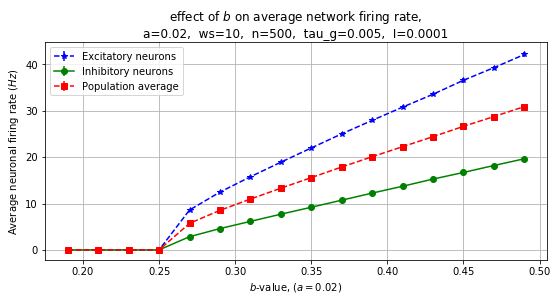

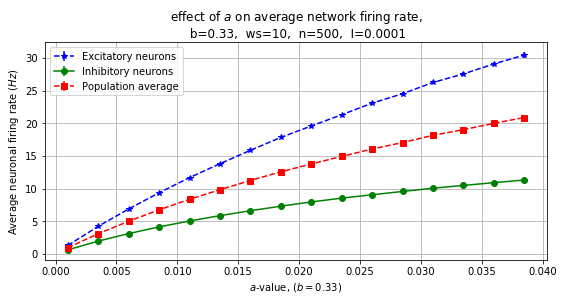

In [14]:
fname = './network experiments/results/v5_results_s_10_n_500.txt'
const_str = 'a'
const_val = 0.02
parsed_data = read_from_logfile_for_const(fname, const_value=const_val, const_str=const_str);
plot_parsed_data(parsed_data, var_str='b', const_str=const_str, const_val=const_val)

fname = './network experiments/results/v5_results_s_10_n_500_b_const.txt'
const_str = 'b'
const_val = 0.33
parsed_data = read_from_logfile_for_const(fname, const_value=const_val, const_str=const_str);
plot_parsed_data(parsed_data, var_str='a', const_str=const_str, const_val=const_val)